# K-means Clustering

In this notebook, we explore the realm of partitioning methods in cluster analysis. Using K-means clustering, we will divide our dataset into K distinct, non-overlapping subsets to investigate the alpha-rich and α-normal disk of the Milky Way.

Before diving into this lab, you should have some familiarity with K-means clustering and partitioning methods in general. These techniques are foundational in machine learning and statistical modeling for tasks such as data segmentation, cluster analysis, and feature extraction. Typically, K-means clustering categorizes data into 'K' number of centroids, and each data point belongs to the cluster with the nearest centroid.

#### Learning Outcomes

- **Modelling Data with K-means Clustering**:
Upon completing this lab, you should be well-equipped to apply K-means clustering to various types of data. You will learn not just how to fit the model but also how to interpret the clusters and their relevance in the context of the dataset.

- **Visualising the Convergence of the K-means Algorithm**:
Visual representation can be a powerful tool in understanding algorithmic behavior. In this lab, you will learn techniques for plotting the progress of your K-means clustering as it iterates to find the optimal centroids. This will provide insights into the speed of convergence and the stability of your model, as well as offering a compelling way to demonstrate your results.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol


## Recap of K-means Clustering

K-means clustering offers a straightforward approach to partition a complex dataset into $K$ distinct clusters. Given a dataset $\{\mathbf{x}_1, \ldots, \mathbf{x}_n \}$ where each $\mathbf{x}_i \in \mathbb{R}^D$, K-means aims to find $K$ centroids such that the sum of the squared distances from each point to its assigned centroid is minimized. The objective function $J$ (or known as the inertia) is given by:

$$
J = \sum_{i=1}^N \sum_{k=1}^{K} r_{ik} \| \mathbf{x}_i - \mu_k \|^2
$$

Here, $r_{ik}$ is an indicator variable that is 1 if $\mathbf{x}_i$ is assigned to cluster $k$ and 0 otherwise, and $\mu_k$ is the centroid of cluster $k$.

### How Assignment Works

At each iteration, each data point is assigned to the nearest centroid, and the centroids are recalculated as the mean of all points currently assigned to the cluster. Specifically, if $r_{ik} = 1$, $\mathbf{x}_i$ is assigned to $\mu_k$.

### Iterative Optimization

K-means uses an iterative refinement technique to optimize the centroids:

- **Step 1 (Initialization)**: Choose initial values for the centroids $\mu_1, \mu_2, \ldots, \mu_K$.
- **Step 2 (Assignment)**: Assign each $\mathbf{x}_i$ to the nearest centroid, updating $r_{ik}$.
- **Step 3 (Update)**: Recalculate centroids based on the current cluster assignments:

$$
\mu_k = \frac{\sum_{i=1}^N r_{ik} \mathbf{x}_i}{\sum_{i=1}^N r_{ik}}
$$

- **Step 4 (Convergence Check)**: If the centroids have not changed significantly or a set number of iterations have been reached, the algorithm terminates.

### Summary of Variables

Here is a handy table summarizing the variables involved:

| Variable      | Type       | Description                                                                                          | Known? |
|---------------|------------|------------------------------------------------------------------------------------------------------|--------|
| $N$         | $\mathbb{N}$ | Number of data points                                                                                 | Yes    |
| $D$         | $\mathbb{N}$ | Dimension of data points                                                                              | Yes    |
| $K$         | $\mathbb{N}$ | Number of clusters                                                                                    | Yes    |
| $\mathbf{x}_i$ | $\mathbb{R}^D$ | A data point                                                                                          | Yes    |
| $X$         | $\mathbb{R}^{N \times D}$ | Data matrix                                                                                          | Yes    |
| $r_{ik}$    | $\mathbb{R}$ | Indicator variable for the $k$th cluster to explain the observation $\mathbf{x}_i$                 | No     |
| $\mu_k$     | $\mathbb{R}^D$ | The centroid of the $k$th cluster                                                                   | No     |
| $J$         | $\mathbb{R}$ | Objective function to be minimized                                                                     | No     |


## The Dataset 

In this study, our primary aim is to distinguish between two unique stellar populations in the Milky Way galaxy: the $\alpha$-rich and $\alpha$-normal disk stars.

The elemental composition of stars in our galaxy exhibits a bimodal distribution, particularly in terms of $\alpha$ elements like Oxygen, Magnesium, and Silicon, as compared to elements such as Iron (Fe). The $\alpha$-rich stars are of special interest because they are believed to be from an older generation of stars in the Milky Way. This bimodal distribution is often attributed to the galaxy's evolutionary timeline and the types of supernovae contributing to elemental formation.

#### Galactic Evolution and Type Ia Supernovae

As the galaxy evolves, the role of different types of supernovae in elemental formation changes. Initially, core-collapse supernovae, rich in $\alpha$ elements, dominate. However, over time, Type Ia supernovae, which primarily produce iron-peak elements, become more prevalent. This leads to a decrease in the $\alpha$-to-iron ratio in newer stars, making them $\alpha$-normal.

### Objective and Methodology

Our ultimate goal is to effectively classify these two chemically distinct populations of stars. To accomplish this, we will utilize K-means clustering as our machine learning approach. Although simpler than Gaussian Mixture Models (GMM), K-means is computationally more efficient and could still provide valuable insights into the complex, bimodal distribution of elemental abundances in stars.

To ensure the algorithm's effectiveness, we will normalize the data. Normalization is crucial in K-means clustering because the algorithm inherently assumes spherical clusters. By ensuring that both axes span the same range, we optimize the algorithm's performance in classifying stellar populations.


Text(0, 0.5, 'Normalized [Mg/Fe]')

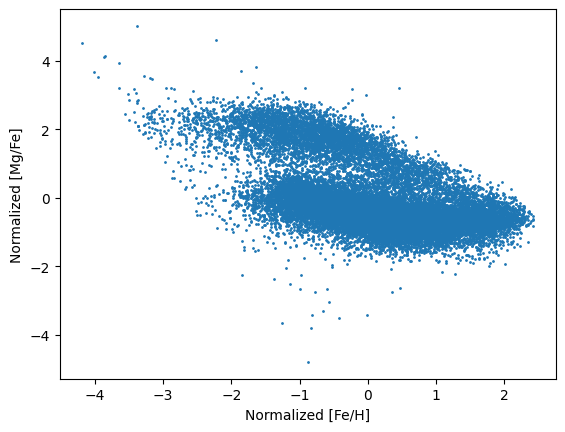

In [4]:
# load data
data = np.load("apogee_sample_tutorial_week8b.npz")
feh = data["feh"]
mgfe = data["mgfe"]

# noramlize data
feh = (feh - np.mean(feh)) / np.std(feh)
mgfe = (mgfe - np.mean(mgfe)) / np.std(mgfe)

data = np.vstack([feh, mgfe]).T
data_labels = ["[Fe/H]", "[Mg/Fe]"]

# plot data
plt.scatter(data[:, 0], data[:, 1], s=1)

plt.xlabel("Normalized [Fe/H]")
plt.ylabel("Normalized [Mg/Fe]")

## Initializing K-means Clustering Parameters

Before running the K-means algorithm on our dataset, it's important to set initial values for the model's centroids. These initializations guide the iterative process of the K-means algorithm. For our problem, we'll use a two-cluster K-means model to capture the bimodal distribution of alpha-enriched and alpha-normal stars.

We will initialize the centroids of our two clusters as follows:

- For the first cluster ($ C_1 $):
$$
\begin{bmatrix}
    -1 \\
    +1
\end{bmatrix}
$$

- For the second cluster ($ C_2 $):
$$
\begin{bmatrix}
    +1 \\
    -1
\end{bmatrix}
$$

By initializing these parameters, we can now proceed with the K-means algorithm to cluster our dataset based on elemental abundances.


In [5]:
# K-means initial centroids
C_0 = np.array([[-1.0, 1.0], [1.0, -1.0]])


## Visualizing the Data and Cluster Centroids

To better understand the iterative process of the K-means algorithm and to visually inspect how well the centroids represent different clusters in the dataset, we plot both the data points and the centroids. Optionally, we can also visualize the "redness" of each data point, which could represent its closeness to a specific centroid or its likelihood of belonging to a particular cluster.

### Helper Functions for Plotting

Below are some Python functions that facilitate the plotting process.

#### plot_data_and_centroids Function

The `plot_data_and_centroids` function serves the primary role of plotting both the data and the centroids on the same chart. Here are the parameters:

- `data`: The actual data points you wish to plot.
- `centroids`: The positions of the centroids.
- `redness`: Optional parameter to color data points based on some metric, which could be their distance to the nearest centroid or some other relevant measure.

This function uses an optional 'redness' parameter to color the data points. When the 'redness' values are provided, each point will be colored on a blue-to-red scale based on this value. This visual cue can help us better understand the cluster assignment at each step of the K-means iteration.

#### Optional: Custom Color Map

A custom color map (`br_cmap`) is defined using Matplotlib's `LinearSegmentedColormap`. This color map is used when coloring data points based on their 'redness' value. The color map transitions from blue to red, allowing for a clear visualization of cluster memberships or distances to centroids.

These helper functions enable us to visually assess how well the K-means algorithm is performing at each iteration and offer insights into the clustering process.


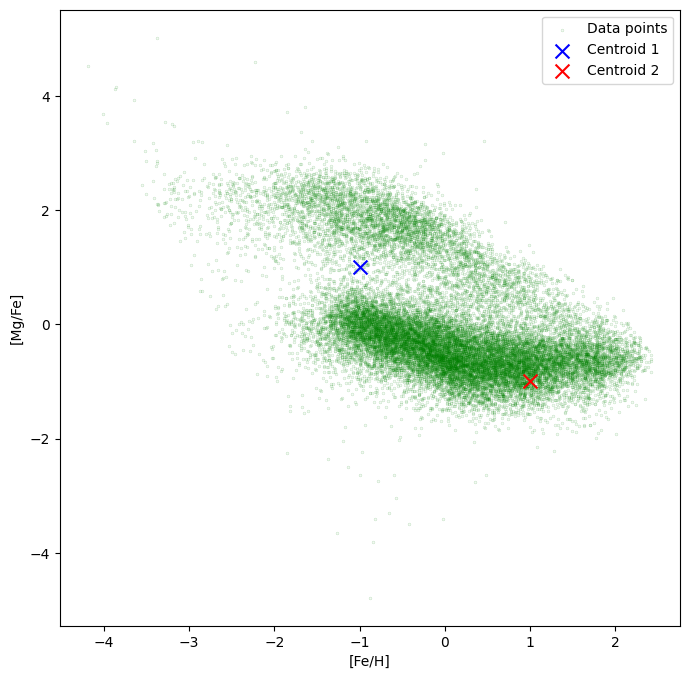

In [6]:
def plot_data_and_centroids(data, centroids, redness=None):
    
    plt.figure(figsize=(8,8))
    
    br_cmap = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])
    
    # Plotting the data points
    if redness is not None:
        assert len(redness) == data.shape[0]
        assert all(_ >= 0 and _ <= 1 for _ in redness)
        c = redness
        plt.scatter(data[:, 0], data[:, 1], c=c, s=0.1, alpha=0.3, linewidths=2, cmap=br_cmap, label="Data points")
    else:
        c = 'g'
        plt.scatter(data[:, 0], data[:, 1], c=c, s=0.1, alpha=0.3, linewidths=2, label="Data points")
    
    # Plotting the centroids with different colors
    centroid_colors = ['b', 'r']
    for i in range(centroids.shape[0]):
        plt.scatter(centroids[i, 0], centroids[i, 1], c=centroid_colors[i], marker='x', s=100, label=f"Centroid {i+1}")
    
    plt.xlabel("[Fe/H]")
    plt.ylabel("[Mg/Fe]")
    plt.legend()
    plt.show()

# Assuming data and initial centroids C_0 are defined earlier, and that 'redness' values are calculated somehow
plot_data_and_centroids(data, C_0)


## Optimizing the K-means Clustering

We know that, the K-means algorithm can be optimized through an iterative approach. This involves two steps: the assignment step, and the update step.

#### Function Signatures

The primary functions involved in K-means are:

- For the E-step or Assignment step
- For the M-step or the Update step

#### Tips

You can make use of the `scipy.spatial.distance` library to compute Euclidean distances between points.

You can use `distance.euclidean(a, b)` to compute the distance between points `a` and `b`.

In this K-means implementation:

1. `assignment_step`: Assigns each data point to the nearest centroid, effectively partitioning the data into clusters.
2. `update_step`: Calculates the new centroids by taking the mean of all the data points in each cluster.

Unlike GMM, K-means doesn't work with covariance matrices, Gaussian components, or weighted probabilities. It's a simpler algorithm in that regard.


In [7]:
from scipy.spatial import distance
import numpy as np

def assignment_step(X, centroids):
    """
    Performs the E-step of the K-means algorithm.
    """
    labels = np.argmin([distance.cdist(X, c.reshape(1, -1), 'euclidean') for c in centroids], axis=0)
    return labels.flatten()

def update_step(X, labels, K):
    """
    Performs the M-step of the K-means algorithm.
    """
    new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(K)])
    return new_centroids

### Evaluating the K-means Model

To evaluate the performance of the K-means model, you can calculate its inertia.

The function computes the inertia by summing up the squared Euclidean distances between each data point and the centroid of its cluster. The resulting value will be a single scalar that measures how well the centroids fit the data $ \mathbf{X} $.


In [8]:
from scipy.spatial import distance
import numpy as np

def calculate_inertia(X, labels, centroids):
    inertia = 0
    for i in range(len(centroids)):
        cluster_points = X[labels == i]
        inertia += np.sum([distance.euclidean(p, centroids[i]) ** 2 for p in cluster_points])
    return inertia

### Monitoring Convergence in K-means

To check if the K-means algorithm is converging, one can track the model's inertia against the number of iterations. The idea is to run K-means for a fixed number of iterations and compute the inertia at each step. This information can then be visualized to assess the algorithm's convergence.


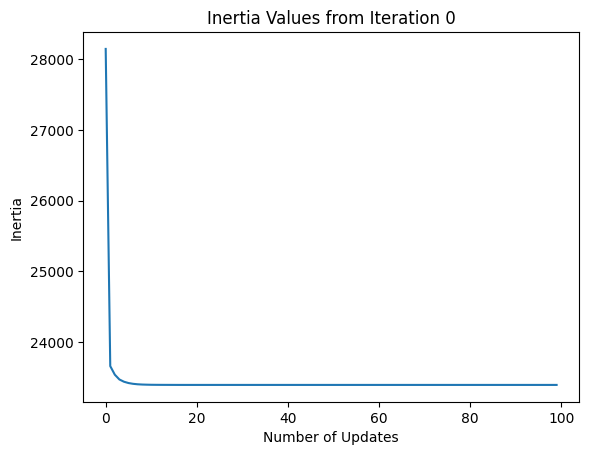

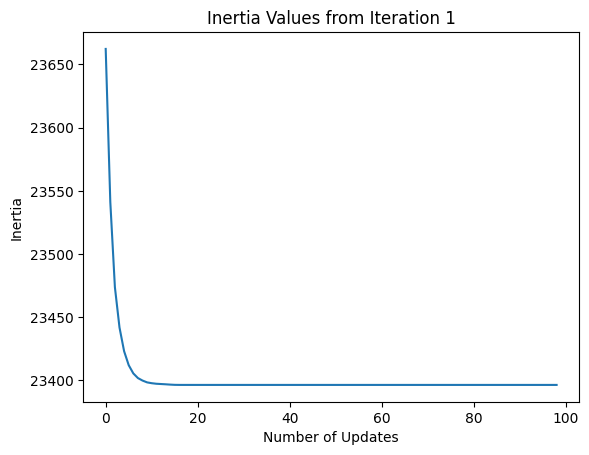

In [9]:
# Assuming `data` is your input data
# Initialize centroids
initial_centroids = C_0  

# Number of clusters
K = 2

# Number of iterations
iterations = 100

# Array to hold the inertia values
inertia_values = np.zeros(iterations)

# Initialize centroids to some starting values (C_0)
centroids = initial_centroids

# Run the K-means algorithm
for i in range(iterations):
    # Perform the Assignment step to update labels
    labels = assignment_step(data, centroids)
    
    # Compute the inertia of the current model
    inertia_values[i] = calculate_inertia(data, labels, centroids)
    
    # Update centroids for the next iteration
    centroids = update_step(data, labels, K)

# Plotting the inertia values from iteration 0
plt.figure()
plt.title("Inertia Values from Iteration 0")
plt.xlabel("Number of Updates")
plt.ylabel("Inertia")
plt.plot(inertia_values)
plt.show()

# Plotting the inertia values starting from iteration 1
plt.figure()
plt.title("Inertia Values from Iteration 1")
plt.xlabel("Number of Updates")
plt.ylabel("Inertia")
plt.plot(inertia_values[1:])
plt.show()


### Visualising EM

Use the function `plot_data_and_centroids` to visualize the data points and your current cluster centroids at different stages of the K-means algorithm.


Iteration 0: Current Inertia = 28145.500469352988


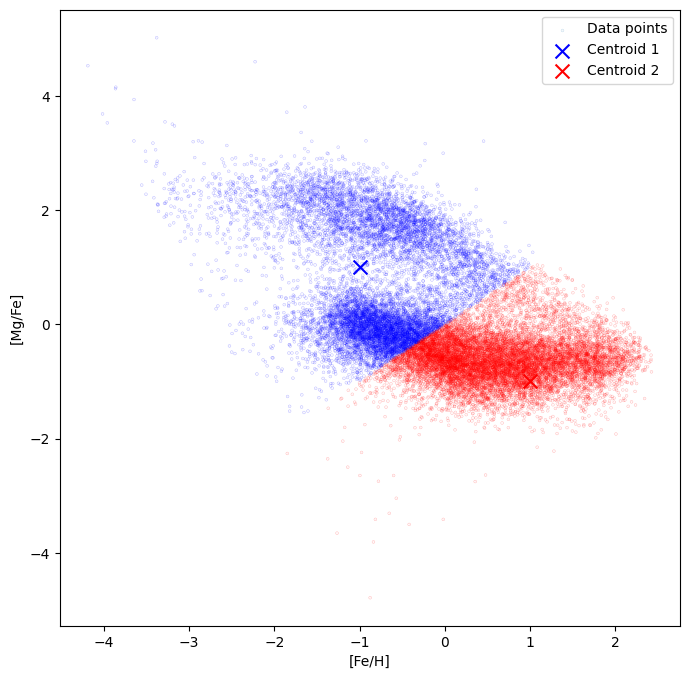

Iteration 5: Current Inertia = 23423.136081332344


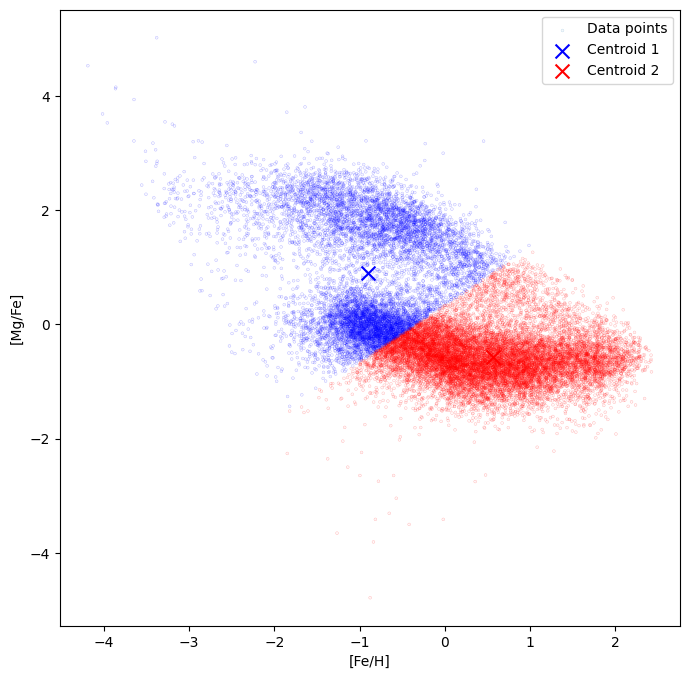

Iteration 10: Current Inertia = 23398.467274363735


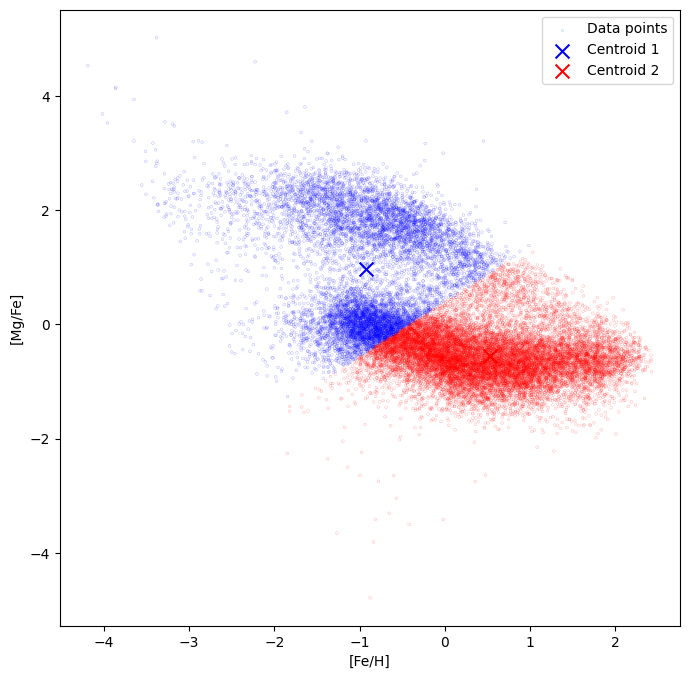

Iteration 15: Current Inertia = 23396.70623759327


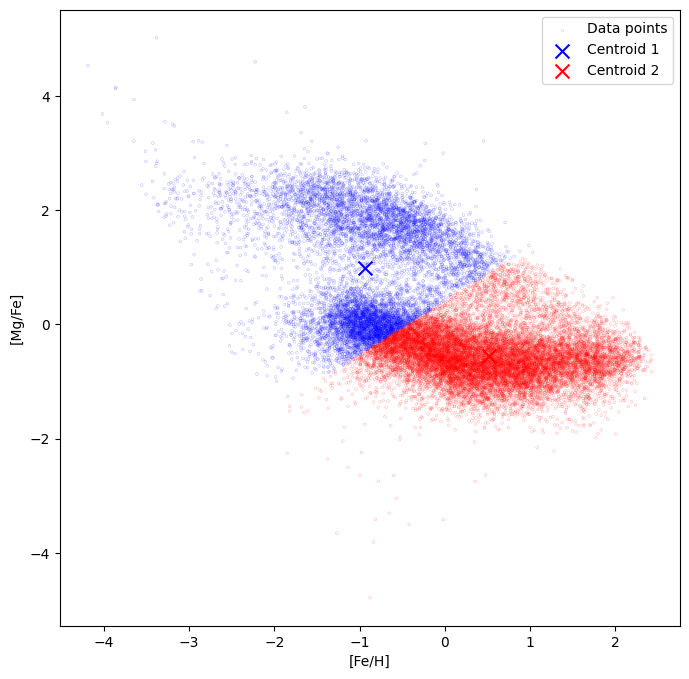

Iteration 20: Current Inertia = 23396.459175983444


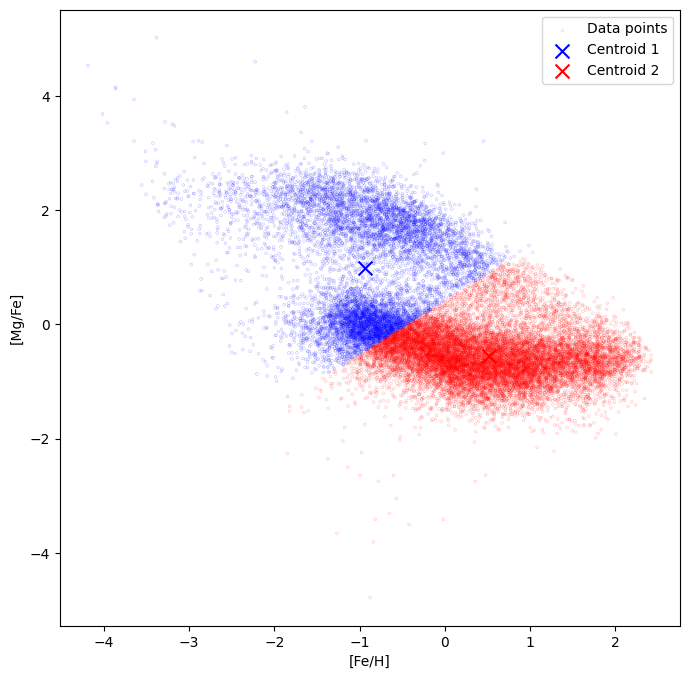

Iteration 25: Current Inertia = 23396.456489393255


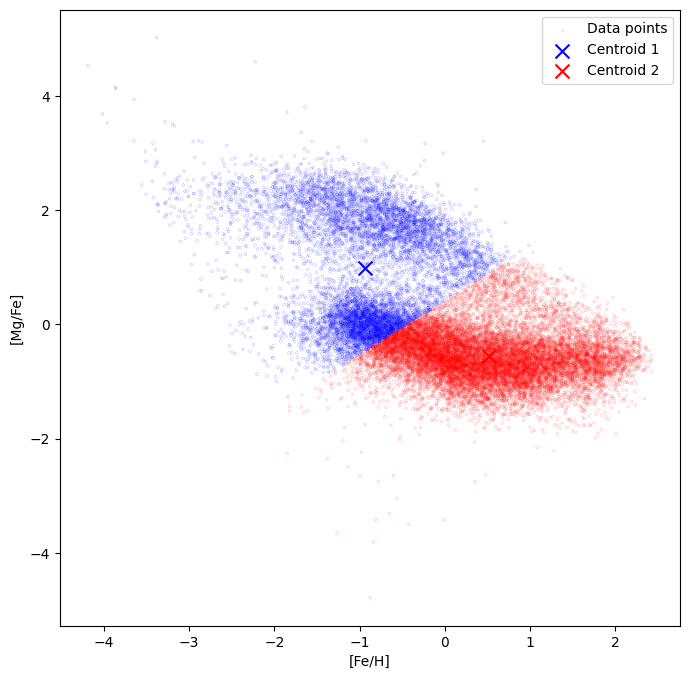

Iteration 30: Current Inertia = 23396.456489393255


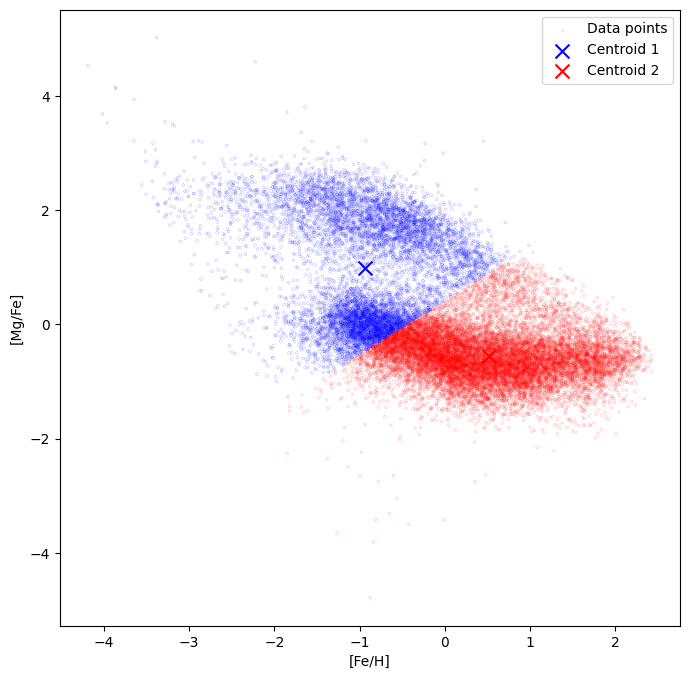

Iteration 35: Current Inertia = 23396.456489393255


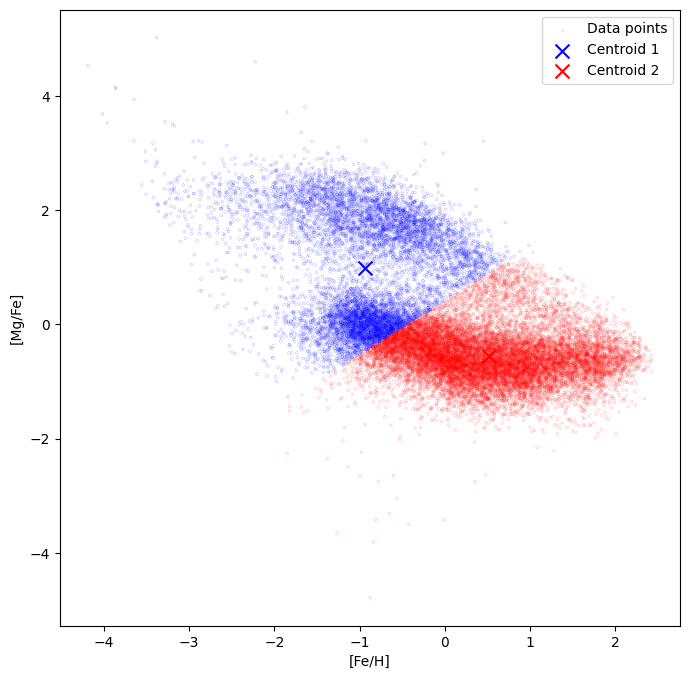

Iteration 40: Current Inertia = 23396.456489393255


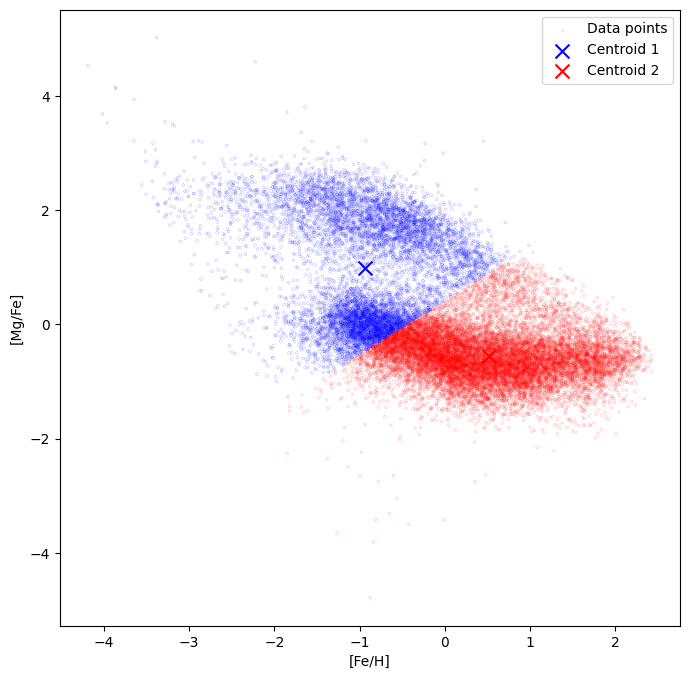

Iteration 45: Current Inertia = 23396.456489393255


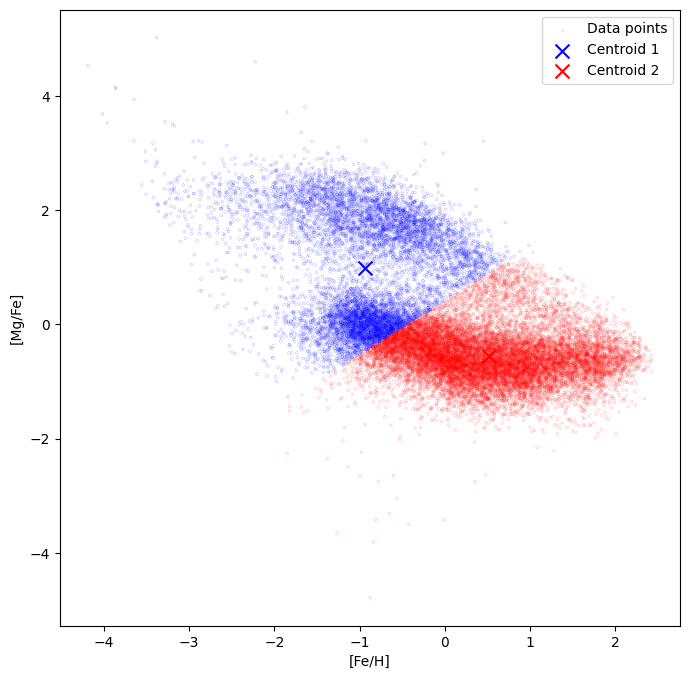

In [11]:
# Initialize centroids to some starting values (C_0)
centroids = C_0 

# Number of clusters
K = 2

# Number of iterations for the K-means algorithm
iterations = 50

# Array to keep track of the inertia values
inertia_values = np.zeros(iterations)

# Run the K-means algorithm
for i in range(iterations):
    
    # Perform the Assignment step to update labels
    labels = assignment_step(data, centroids)
    
    # Compute the inertia of the current model
    inertia_values[i] = calculate_inertia(data, labels, centroids)
    
    # Visualize the model every 5 iterations
    if i % 5 == 0:
        print(f"Iteration {i}: Current Inertia = {inertia_values[i]}")
        
        # Show the current state of the model
        plot_data_and_centroids(data, centroids, redness=labels)
        
    # Perform the Update step to update centroids
    centroids = update_step(data, labels, K)


### Why K-means May Not Work Well 

In our analysis, we observed that the K-means clustering algorithm did not perform well with our elemental abundances data that forms a double moon shape. The reason lies in the assumptions behind the K-means algorithm, particularly its use of Euclidean distance to partition data points into clusters. K-means tries to minimize the variance within each cluster, which is equivalent to minimizing the Euclidean distance from each data point to its cluster's centroid. This works well for clusters that are spherical and equally sized, but not for data with more complex shapes or varying densities.

#### Limitations of K-means:

1. **Spherical Assumption**: K-means assumes that the clusters are spherical and equally sized, which doesn't hold true for double moon-shaped data.
  
2. **Euclidean Distance**: The algorithm uses Euclidean distance to allocate points to the nearest cluster. For more complex shapes like double moons, a different distance measure or model might be more appropriate.
  
3. **Lack of Flexibility**: K-means does not have the flexibility to account for different shapes or orientations of clusters.

To overcome these limitations, we turn to Gaussian Mixture Models (GMMs), a more flexible approach that can model elliptical clusters and is capable of handling different cluster shapes and orientations. Unlike K-means, GMMs do not assume equal-sized or spherical clusters, and they provide a probabilistic framework to capture uncertainty, making them a more suitable option for clustering our double moon-shaped data.


## Summary: K-means Clustering Algorithm

This tutorial provides a comprehensive walkthrough on how to implement and optimize the K-means clustering algorithm. The tutorial covers the core concepts, mathematical foundations, and Python implementations for optimizing the K-means parameters.

#### Key Topics Covered

1. **Introduction to K-means**: An overview of K-means clustering and its applications in different domains.
   
2. **Mathematical Background**: A review of the mathematical foundations, including the role of assignment and update steps in the K-means algorithm.
   
3. **Parameter Estimation**: Discussion on how to calculate the cluster centroids that minimize the inertia or within-cluster sum-of-squares.

4. **Python Implementation**: Practical Python code for implementing the assignment and update steps, along with inertia calculation.

5. **Inertia Evaluation**: A Python function to calculate the inertia of the model, which is crucial for understanding model convergence.

6. **Convergence Visualization**: Graphs plotting the inertia against the number of K-means algorithm iterations, helping to understand if and when the algorithm converges.

7. **Model Visualization**: Code snippets for visualizing how the K-means model adapts over time, providing intuitive insight into the model's learning process.

8. **Limitations and Alternatives**: An exploration of why K-means may not be ideal for all data shapes and what alternatives, like Gaussian Mixture Models, can be considered.
